## Lung Segmentation - Montgomery Dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import tempfile
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.models import load_model

In [3]:
import fastestimator as fe
from fastestimator.architecture import UNet
from fastestimator.dataset import montgomery
from fastestimator.estimator.trace import Dice, ModelSaver
from fastestimator.network.loss import BinaryCrossentropy
from fastestimator.network.model import FEModel, ModelOp
from fastestimator.pipeline.augmentation import Augmentation2D
from fastestimator.pipeline.processing import Minmax
from fastestimator.record.preprocess import ImageReader, Reshape, Resize
from fastestimator.util.op import NumpyOp

## Download and prepare the montgomery dataset


The montgomery dataset API will generate a summary CSV file for the data. The path of the csv file is returned as csv_path. The dataset path is returned as path. Inside the CSV file, the file paths are all relative to path.

In [4]:
train_csv_path, path = montgomery.load_data()

In [5]:
df = pd.read_csv(train_csv_path)
df.head()

,image,mask_left,mask_right
0,MontgomerySet/CXR_png/MCUCXR_0301_1.png,MontgomerySet/leftMask/MCUCXR_0301_1.png,MontgomerySet/rightMask/MCUCXR_0301_1.png
1,MontgomerySet/CXR_png/MCUCXR_0203_1.png,MontgomerySet/leftMask/MCUCXR_0203_1.png,MontgomerySet/rightMask/MCUCXR_0203_1.png
2,MontgomerySet/CXR_png/MCUCXR_0064_0.png,MontgomerySet/leftMask/MCUCXR_0064_0.png,MontgomerySet/rightMask/MCUCXR_0064_0.png
3,MontgomerySet/CXR_png/MCUCXR_0061_0.png,MontgomerySet/leftMask/MCUCXR_0061_0.png,MontgomerySet/rightMask/MCUCXR_0061_0.png
4,MontgomerySet/CXR_png/MCUCXR_0040_0.png,MontgomerySet/leftMask/MCUCXR_0040_0.png,MontgomerySet/rightMask/MCUCXR_0040_0.png


## Create TF Records from input image and mask

RecordWriter api shall convert the training images and masks into 'TF Records'. Writing of training dataset into TF-Records is preceded by the following processing of the feature  'image', 'mask_left' and 'mask_left'. <br>

Processing( transformation ) are carried out using 'Operations'.<br>
Operation can be seen as processing step over feature(s). Operation can generate newer feature(s) or can update existing feature(s). 


Preprocessing step for feature 'image' :  <br>
    'image' = ImageReader('image') <br>
    'image' = Resize('image')  <br>
    'image' = Reshape('image')  <br>
    
Preprocessing step for feature 'mask_left' and 'mask_right': <br>
    'mask' = ImageReader('mask_left') + ImageReader('mask_right')  <br>
    'CombinedLeftRightMask' does the addition between left mask and right mask <br>
    'mask'  = Resize('mask')  <br>
    'mask'  = Reshape('mask')  <br>

    
    

In [6]:
class CombineLeftRightMask(NumpyOp):
    def forward(self, data, state):
        mask_left, mask_right = data
        data = mask_left + mask_right
        return data


In [7]:
writer = fe.RecordWriter(
        save_dir=os.path.join(path, "FEdata"),
        train_data=train_csv_path,
        validation_data=0.2,
        ops=[
            ImageReader(grey_scale=True, inputs="image", parent_path=path, outputs="image"),
            ImageReader(grey_scale=True, inputs="mask_left", parent_path=path, outputs="mask_left"),
            ImageReader(grey_scale=True, inputs="mask_right", parent_path=path, outputs="mask_right"),
            CombineLeftRightMask(inputs=("mask_left", "mask_right")),
            Resize(target_size=(512, 512)),
            Reshape(shape=(512, 512, 1), outputs="mask"),
            Resize(inputs="image", target_size=(512, 512)),
            Reshape(shape=(512, 512, 1), outputs="image"),
        ],
        write_feature=["image", "mask"])

## Create data pipeline

Pipeline api generates sample batches one at a time, from TF Records. Preprocessing steps on feature 'image' and 'mask' are as follow:<br>
    'image' = Augmentation('image')  - rotation and flip being the type of augmentation <br>
    'mask' = Augmentation('mask')  - rotation and flip <br>
    'image' = Minmax('image') <br>
    'mask' = Minmax('mask') <br>
    



In [8]:
batch_size=4
epochs = 25

In [9]:
pipeline = fe.Pipeline(
    batch_size=batch_size,
    data=writer,
    ops=[ 
        Augmentation2D(inputs=["image", "mask"], outputs=["image", "mask"], mode="train", rotation_range=10, flip_left_right=False),
        Minmax(inputs="image", outputs="image"),
        Minmax(inputs="mask", outputs="mask")
    ])

## Check the results of preprocessing 

FastEstimator: Saving tfrecord to /tmp/.fe/MONTGOMERY/FEdata
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 7.1%, Speed: 16.10 record/sec
FastEstimator: Converting Train TFRecords 14.3%, Speed: 16.86 record/sec
FastEstimator: Converting Train TFRecords 21.4%, Speed: 17.94 record/sec
FastEstimator: Converting Train TFRecords 28.6%, Speed: 18.30 record/sec
FastEstimator: Converting Train TFRecords 35.7%, Speed: 18.52 record/sec
FastEstimator: Converting Train TFRecords 42.9%, Speed: 18.54 record/sec
FastEstimator: Converting Train TFRecords 50.0%, Speed: 18.45 record/sec
FastEstimator: Converting Train TFRecords 57.1%, Speed: 18.78 record/sec
FastEstimator: Converting Train TFRecords 64.3%, Speed: 18.93 record/sec
FastEstimator: Converting Train TFRecords 71.4%, Speed: 18.89 record/sec
FastEstimator: Converting Train TFRecords 78.6%, Speed: 19.05 record/sec
FastEstimator: Converting Train TFRecords 85.7%, Speed: 18.92 reco

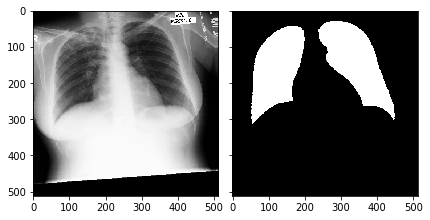

In [10]:
idx = np.random.randint(low=0,high=batch_size)
fig, ax =  plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,  figsize = (6,6), squeeze=True)
sample_data = pipeline.show_results(mode='train')
sample_img = sample_data[0]['image'][idx]
sample_mask = sample_data[0]['mask'][idx]
ax[0].imshow(np.squeeze(sample_img), cmap='gray')
ax[1].imshow(np.squeeze(sample_mask), cmap='gray')
plt.tight_layout()
plt.show()

## Creation of the network

FEModel api enables to create a model for training. It accepts a function as argument which return tf.keras.model,
it also accept optimizer type to perform optimization on network weights.

In [12]:
model_dir=tempfile.mkdtemp()

model = FEModel(model_def=lambda: UNet(input_size=(512, 512, 1)),
                    model_name="lung_segmentation",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

Network api enables user to constitute a network as a sequence of operations. 

The model defined in the previous step is seen as an operation. 

Operation can be seen as processing step over feature(s). Operation can generate newer feature(s) or can update existing feature(s). 

Along with model defined in previous step, BinaryCrossEntropy is another operation added to the network. By default this operation generates a  'loss' and in this example, from feature 'pred_segment' which is prediction result  and 'mask' which is ground truth.

In [13]:
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    BinaryCrossentropy(y_true="mask", y_pred="pred_segment")
])

Trace defined here are 'Dice' and 'ModelSaver'. Trace can be seen as tf.keras callbacks.

In [14]:
traces = [
    Dice(true_key="mask", pred_key="pred_segment"),
    ModelSaver(model_name="lung_segmentation", save_dir=model_dir, save_best=True)
]

Estimator api accepts network object, pipeline object , number of epochs and trace object and returns an estimator object which can orchestrate the training loop on the training data along with evaluaton on validation data.

In [15]:
estimator = fe.Estimator(network=network, pipeline=pipeline, epochs=epochs, log_steps=20, traces=traces)

In [ ]:
estimator.fit()

##  Let's do Inference

Inference in done here on validation batch set.

In [19]:
pipeline = fe.Pipeline(
    batch_size=batch_size,
    data=writer,
    ops=[ 
        Augmentation2D(inputs=["image", "mask"], outputs=["image", "mask"], mode="train", rotation_range=10, flip_left_right=False),
        Minmax(inputs="image", outputs="image"),
        Minmax(inputs="mask", outputs="mask")
    ])

sample_data = pipeline.show_results(mode='eval')

FastEstimator: Reading non-empty directory: /tmp/.fe/MONTGOMERY/FEdata
FastEstimator: Found 111 examples for train in /tmp/.fe/MONTGOMERY/FEdata/train_summary0.json
FastEstimator: Found 27 examples for eval in /tmp/.fe/MONTGOMERY/FEdata/eval_summary0.json


In [ ]:
predict_model = load_model(os.path.join(model_dir, 'lung_segmentation_best_loss.h5'), compile=False)
predict_batch = predict_model.predict(sample_data[0]['image'])

Display a image, predicted mask and overlay version. Image sample is randomly selected from the validation batch. 

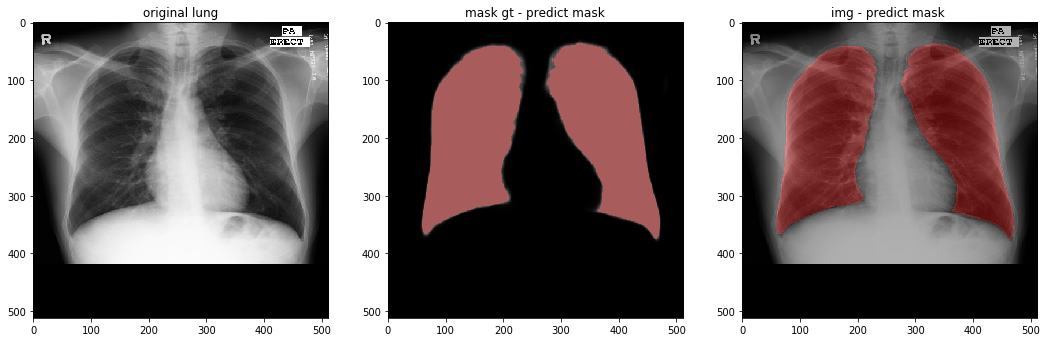

In [23]:

idx = np.random.randint(low=0,high=batch_size)

img = sample_data[0]['image'][idx]
img = img.numpy()
img = img.reshape(512,512)
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_rgb = (img_rgb*255).astype(np.uint8)

mask_gt = sample_data[0]['mask'][idx]
mask_gt = mask_gt.numpy()
mask_gt = mask_gt.reshape(512, 512)
mask_gt_rgb = cv2.cvtColor(mask_gt, cv2.COLOR_GRAY2RGB)
mask_gt_rgb = (mask_gt_rgb).astype(np.uint8)

mask = predict_batch[idx]
mask = mask.reshape(512,512)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
mask_rgb = (mask_rgb*255).astype(np.uint8)

ret, mask_thres = cv2.threshold(mask, 0.5,1, cv2.THRESH_BINARY)
mask_overlay = mask_rgb * np.expand_dims(mask_thres,axis=-1)
mask_overlay = np.where( mask_overlay != [0,0,0], [255,0,0] ,[0,0,0])
mask_overlay = mask_overlay.astype(np.uint8)
img_with_mask = cv2.addWeighted(img_rgb, 0.7, mask_overlay, 0.3,0 )

maskgt_with_maskpred = cv2.addWeighted(mask_rgb, 0.7, mask_overlay, 0.3, 0)

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,8))
ax[0].imshow(img_rgb)
ax[0].set_title('original lung')
ax[1].imshow(maskgt_with_maskpred)
ax[1].set_title('mask gt - predict mask')
ax[2].imshow(img_with_mask)
ax[2].set_title('img - predict mask ')
plt.show()